# Simulador do Sistema da Paraíba do Sul: Exploração de Resultados
## Baixe e execute esse notebook para display dos gráficos.

# Importando bibliotecas:

In [1]:
using DataFrames, CSV, Dates, Measures, Statistics, StatsPlots
gr()

Plots.GRBackend()

## Executa simulação e gera resultados do caso exemplo:

In [2]:
dir = "example"
include("./src/simulatorParaibaDoSul.jl")
SPS = simulatorParaibaDoSul
SPS.run_simulation(dir)

########### Simulation Start ###########
Simulation progress: 0.09363295880149813%
Simulation progress: 0.18726591760299627%
Simulation progress: 0.2808988764044944%
Simulation progress: 0.37453183520599254%
Simulation progress: 0.4681647940074906%
Simulation progress: 0.5617977528089888%
Simulation progress: 0.6554307116104869%
Simulation progress: 0.7490636704119851%
Simulation progress: 0.8426966292134831%
Simulation progress: 0.9363295880149812%
Simulation progress: 1.0299625468164795%
Simulation progress: 1.1235955056179776%
Simulation progress: 1.2172284644194757%
Simulation progress: 1.3108614232209739%
Simulation progress: 1.404494382022472%
Simulation progress: 1.4981273408239701%
Simulation progress: 1.591760299625468%
Simulation progress: 1.6853932584269662%
Simulation progress: 1.7790262172284643%
Simulation progress: 1.8726591760299625%
Simulation progress: 1.9662921348314606%
Simulation progress: 2.059925093632959%
Simulation progress: 2.153558052434457%
Simulation progre

"Simulation complete, results available at: example/results"

## Lê resultados:

In [3]:
df_generation = DataFrame(CSV.File(joinpath(dir,"results",dir*"_generation_MW.csv")))
df_turbining = DataFrame(CSV.File(joinpath(dir,"results",dir*"_turbining_m3_per_sec.csv")))
df_spillage = DataFrame(CSV.File(joinpath(dir,"results",dir*"_spillage_m3_per_sec.csv")))
first(df_generation, 5)

,step,month,stage,ps_equivalent_reservoir,paraibuna,simplicio,sta_branca
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,1,0.927219,8.22244,265.262,10.1933
2,2,2,1,0.99829,87.9353,265.262,43.8082
3,3,3,1,1.0,87.9353,265.262,51.2906
4,4,4,1,1.0,60.1794,265.262,35.7985
5,5,5,1,1.0,44.9263,255.219,26.4925


## Apresenta reservatório equivalente ao longo do tempo, e respectivos estágios de deplecionamento.

### A correlação entre o valor do reservatório equivalente e os estágios de deplecionamento se torna clara. Períodos de alta ou baixa de água são visíveis e na maioria das vezes periódicos.

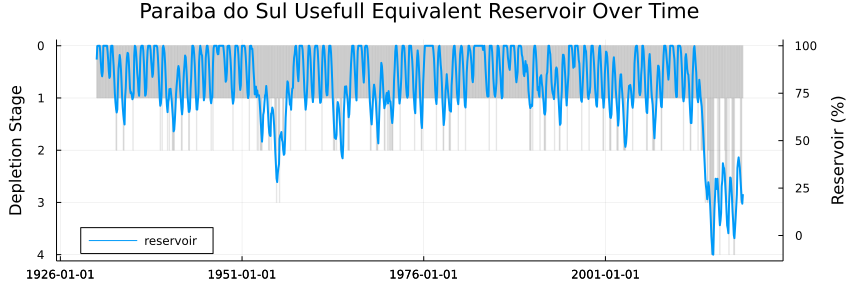

In [4]:
time = Date(1931):Month(1):Date(1931)+Month(size(df_generation,1)-1)
eq_reservoir = df_generation[:,"ps_equivalent_reservoir"]
stages = df_generation[:,"stage"]

bar(time,stages,
    ylabel = "Depletion Stage",
    color = "grey",
    alpha = 0.08,
    legend = false,
    size = (900,300),
    title = "Paraiba do Sul Usefull Equivalent Reservoir Over Time",
    margin=5mm,
    right_margin = 15mm,
    yflip = true
)


p = plot!(twinx(),time,eq_reservoir*100,
    label = "reservoir",
    ylabel = "Reservoir (%)",
    lw = 2,
    margin=5mm,
    size = (850,300),
    legend = :bottomleft
)

savefig("figures//figure_1.png")
p

## Apresenta distribuição de Vertimento e Turbinamento de Santa Cecília:

### Valores de interesse, como vertimento e turbinamento mínimo, ganham destaque no resultado, como era de se esperar pelas suas regras operativas. 

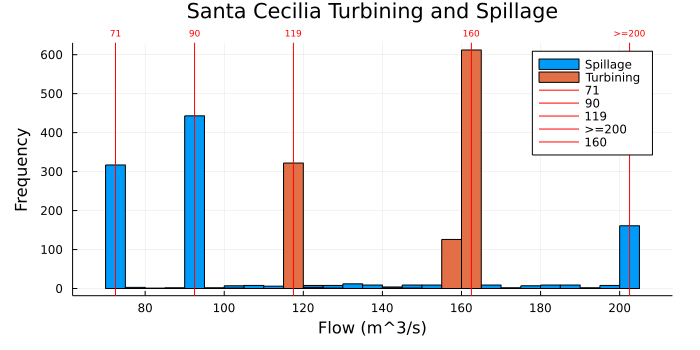

In [5]:
sta_cecilia_spillage = df_spillage[:,"sta_cecilia"]
sta_cecilia_turbining = df_turbining[:,"sta_cecilia"]

df_sta_cecilia = DataFrame(Dict(
    "Turbining m^{3}/s" => sta_cecilia_turbining,
    "Spillage m^{3}/s" => sta_cecilia_spillage,
))

sta_cecilia_spillage = [spill < 200 ? spill : 200 for spill in sta_cecilia_spillage]

histogram(sta_cecilia_spillage,
    bins = 30,
    label = "Spillage",
    title = "Santa Cecilia Turbining and Spillage",
    xlabel = "Flow (m^3/s)",
    ylabel = "Frequency",
    size = (700,350),
    margin = 5mm
)
histogram!(sta_cecilia_turbining,
    bins = 20,
    label = "Turbining"
)

plot!([70+2.5], seriestype="vline",color=:red,label = "71")
annotate!(70+2.5, 655, text(string(71), :red, 6))

plot!([90+2.5], seriestype="vline",color=:red,label="90")
annotate!(90+2.5, 655, text(string(90), :red, 6))

plot!([115+2.5], seriestype="vline",color=:red,label="119")
annotate!(115+2.5, 655, text(string(119), :red, 6))

p = plot!([200+2.5], seriestype="vline",color=:red,label=">=200")
annotate!(200+2.5, 655, text(">=200", :red, 6))

p = plot!([160+2.5], seriestype="vline",color=:red,label="160")
annotate!(160+2.5, 655, text(string(160), :red, 6))

savefig("figures//figure_2.png")
p

## Apresenta geração média do simulador vs SUISHI:

### Pode ser visto que os valores são bem próximos.

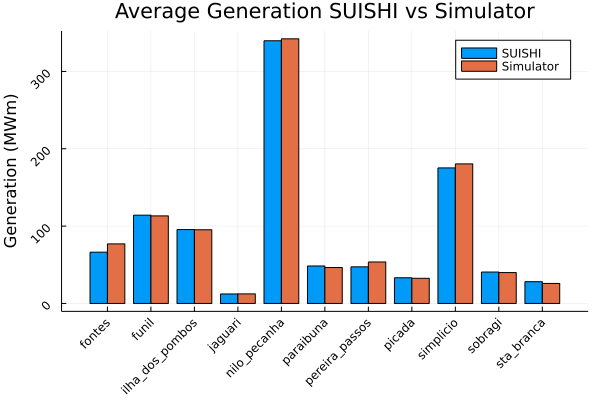

In [6]:
df_generation[:,"fontes"] = df_generation[:,"fontes_a"] + df_generation[:,"fontes_bc"]
labels = [
    "paraibuna",
    "simplicio",
    "sta_branca",
    "jaguari",
    "ilha_dos_pombos",
    "funil",
    "sobragi",
    "fontes",
    "nilo_pecanha",
    "picada",
    "pereira_passos"
]
simulator_means = mean.(eachcol(df_generation[:,labels]))
suishi_means = [48.425, 175.28, 28.154, 12.288, 95.542, 114.145, 40.571, 66.286, 339.645, 33.178, 47.305]
df_suishi_means = DataFrame(Dict(labels[i] => suishi_means[i] for i in 1:length(suishi_means)))
p = StatsPlots.groupedbar(repeat(labels,outer=2),[simulator_means suishi_means],
    rotation = 45,
    title = "Average Generation SUISHI vs Simulator",
    ylabel = "Generation (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulator", "SUISHI"], inner = 11)
)

savefig("figures//figure_3.png")
p

## Apresenta geração média do simulador vs SUISHI agrupados pelas plantas da Light ou todas:

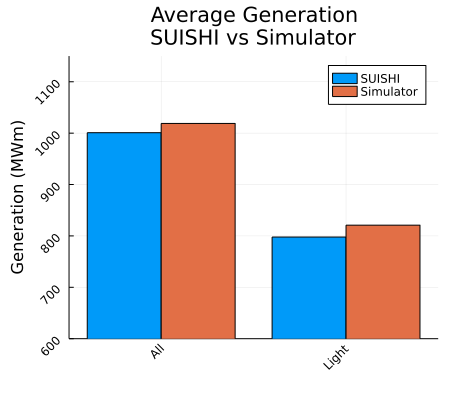

In [7]:
light = ["simplicio","ilha_dos_pombos","sobragi","fontes","nilo_pecanha","picada","pereira_passos"]
total_means = [sum(simulator_means); sum(suishi_means)]
light_means = [sum(mean.(eachcol(df_generation[:,light]))); sum(df_suishi_means[1,light])]
p = StatsPlots.groupedbar(repeat(["All","Light"],outer=2),[total_means light_means]',
    rotation = 45,
    title = "Average Generation\nSUISHI vs Simulator",
    ylabel = "Generation (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulator", "SUISHI"], inner = 2),
    ylim = (600,1150),
    size = (450,400)
)

savefig("figures//figure_4.png")
p

## Apresenta geração média do simulador no período crítico vs no período completo:

### Como esperado, valores no período crítico são ligeiramente menores do que o normal.

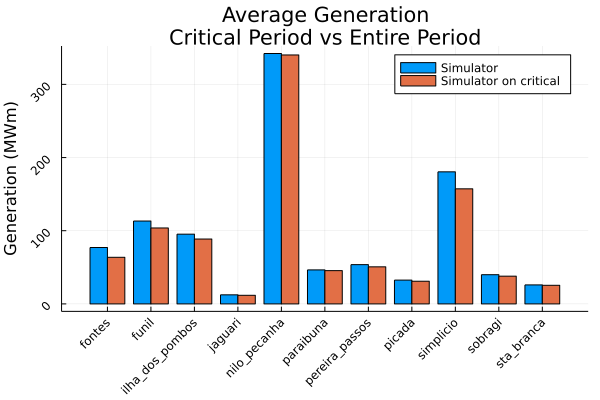

In [8]:
df_critical = df_generation[222:311,labels]
bar(labels,sum.(eachcol(df_critical)),
    rotation = 45,
    bottom_margin = 8mm,
    title = "Total Generation Critical Period \n (Jun-1949 to Nov-1956)",
    legend = false,
    ylabel = "Generation (MW)"
)

simulator_means = mean.(eachcol(df_generation[:,labels]))
critical_means = mean.(eachcol(df_critical))

p =StatsPlots.groupedbar(repeat(labels,outer=2),[simulator_means critical_means],
    rotation = 45,
    title = "Average Generation\nCritical Period vs Entire Period",
    ylabel = "Generation (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulator", "Simulator on critical"], inner = 11)
)
savefig("figures//figure_5.png")
p

## Apresenta geração média durante período crítico do simulador vs SUISHI agrupados pelas plantas da Light ou todas:

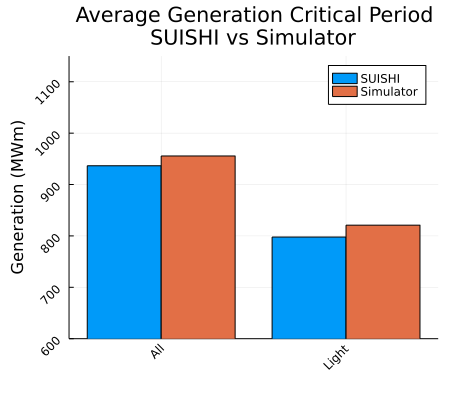

In [9]:
simulator_means = mean.(eachcol(df_critical[:,labels]))
suishi_means = [45.927, 152.505, 26.901, 11.239, 87.228,102.236,38.5,32.8+23.964,337.717,31.641,45.917]
total_means = [sum(simulator_means); sum(suishi_means)]
light_means = [sum(mean.(eachcol(df_generation[:,light]))); sum(df_suishi_means[1,light])]
p = StatsPlots.groupedbar(repeat(["All","Light"],outer=2),[total_means light_means]',
    rotation = 45,
    title = "Average Generation Critical Period\nSUISHI vs Simulator",
    ylabel = "Generation (MWm)",
    bottom_margin = 5mm,
    groups = repeat(["Simulator", "SUISHI"], inner = 2),
    ylim = (600,1150),
    size = (450,400)
)

savefig("figures//figure_6.png")
p